In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('DBLP-V3')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema, prefix_id=True)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

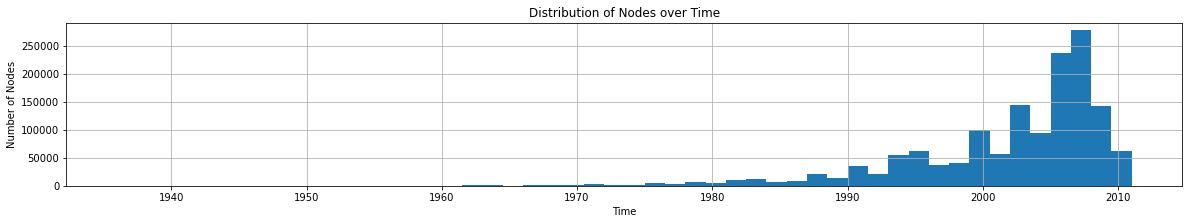

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 2677140
Number of Edges: 8243751
Density: 1.1502251562831148e-06


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 6.158625249333244
Median Degree: 3.0


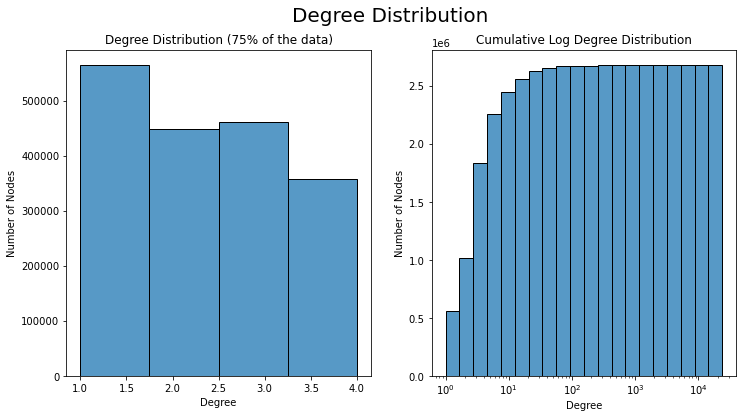

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,23730,CoRR
1,18243,
2,10236,ICRA
3,10204,Discrete Mathematics
4,9234,Commun. ACM
5,8403,Theor. Comput. Sci.
6,7889,IEICE Transactions
7,7465,"Microwave Theory and Techniques, IEEE Transact..."
8,7385,IEEE Transactions on Information Theory
9,7092,Electronics Letters


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.021
Diameter: 19


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    u = 0
    # metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Betweenness Centrality Error: 'Author:A. Achour'


,degree_centrality,page_rank,transitivity
count,2.676768e+06,2.676768e+06,2.112882e+06
mean,2.289310e-06,3.735849e-07,2.874701e-02
std,1.413239e-05,3.598892e-06,8.514798e-02
min,3.735850e-07,5.605514e-08,0.000000e+00
25%,7.471700e-07,1.178712e-07,0.000000e+00
50%,1.120755e-06,1.830566e-07,0.000000e+00
75%,1.867925e-06,3.751647e-07,0.000000e+00
max,8.865172e-03,3.009207e-03,1.000000e+00


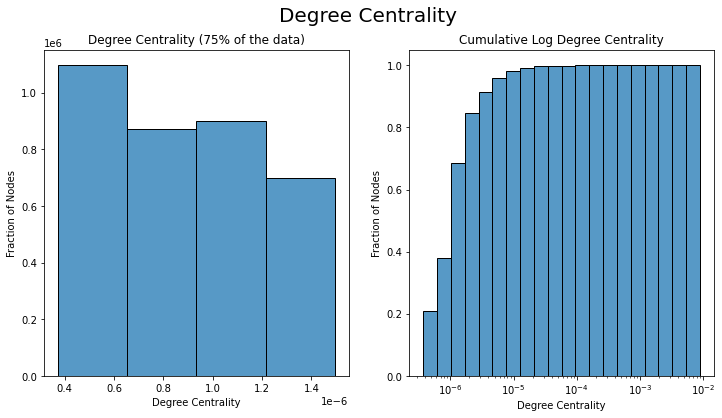

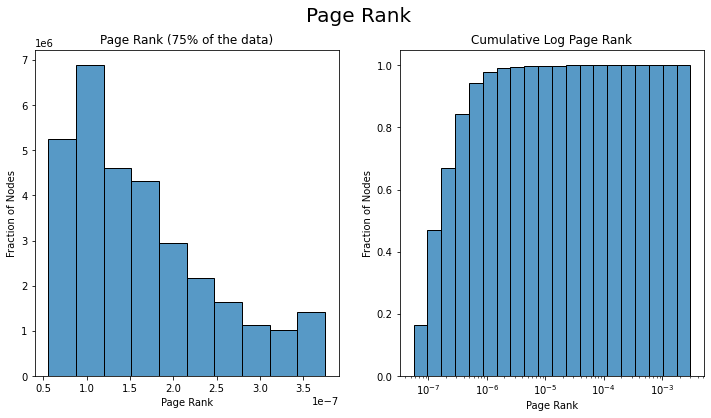

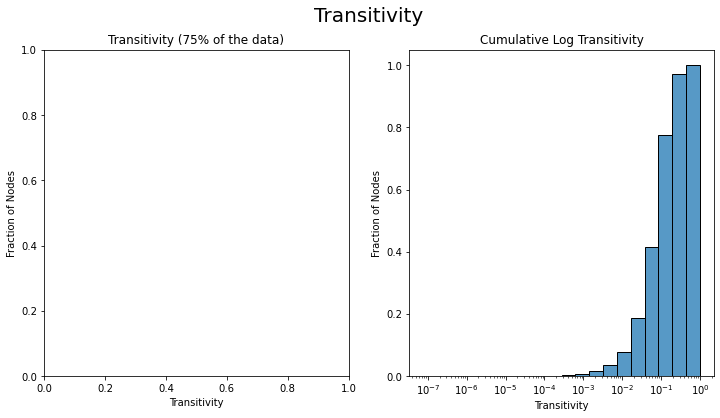

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008865,CoRR,0.003009,,1.0,Leonard Sieger
1,0.006815,,0.002309,CoRR,1.0,Célia Francisca dos Santos
2,0.003824,ICRA,0.001139,Discrete Mathematics,1.0,James C. Schaaf Jr.
3,0.003812,Discrete Mathematics,0.000868,"Microwave Theory and Techniques, IEEE Transact...",1.0,Chun-Keng Liu
4,0.003450,Commun. ACM,0.000852,ICRA,1.0,Ivan Mak
5,0.003139,Theor. Comput. Sci.,0.000788,Commun. ACM,1.0,Maan Kousa
6,0.002947,IEICE Transactions,0.000761,IEEE Transactions on Information Theory,1.0,Vijay R. Chandrasekhar
7,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.000722,"Antennas and Propagation, IEEE Transactions on",1.0,Régis Dupont
8,0.002759,IEEE Transactions on Information Theory,0.000708,"Automatic Control, IEEE Transactions on",1.0,R. Sreerama Kumar
9,0.002649,Electronics Letters,0.000663,Applied Mathematics and Computation,1.0,K. G. Jolly


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 99
Size of the largest component: 2676768


Text(0.5, 1.0, 'Connected Components')

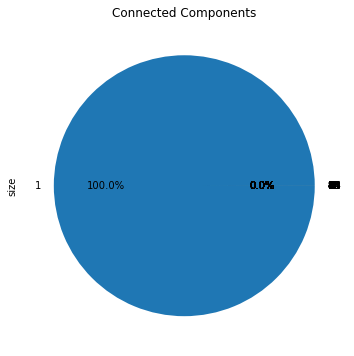

In [21]:
df_tmp = pd.Series(list(map(len, G.components("weak"))), name='size', index=range(1,len(G.components("weak"))+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
Author,Author,1036991,4.132676,1.0
Paper,Paper,1632442,6.475698,4.0
Venue,Venue,7707,211.593746,48.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

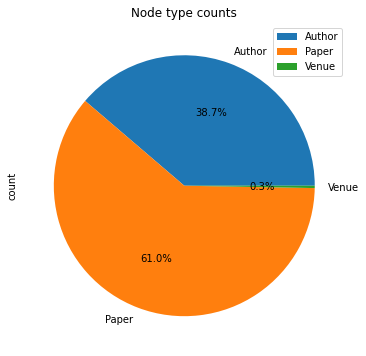

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

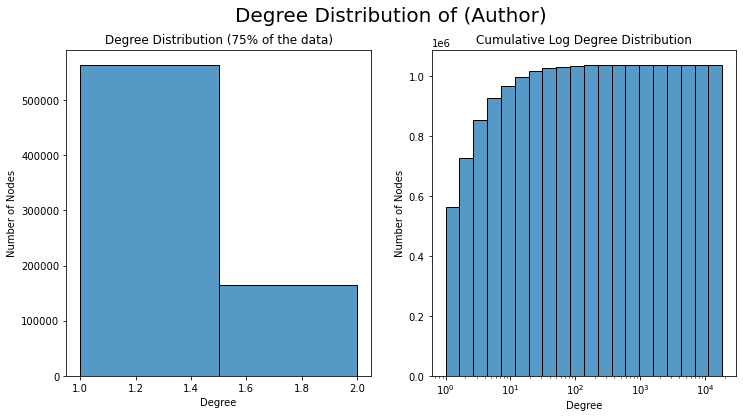

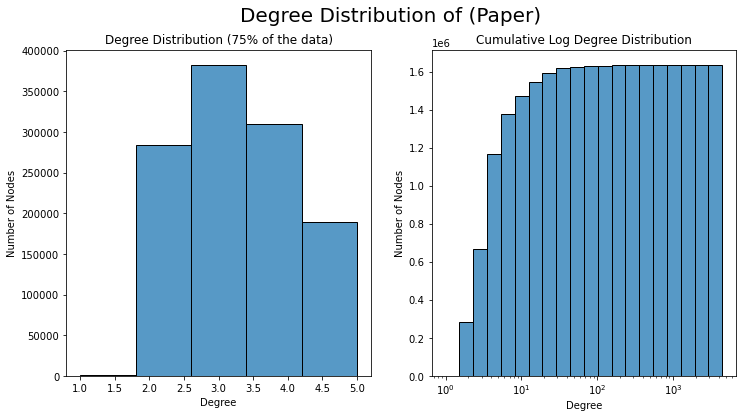

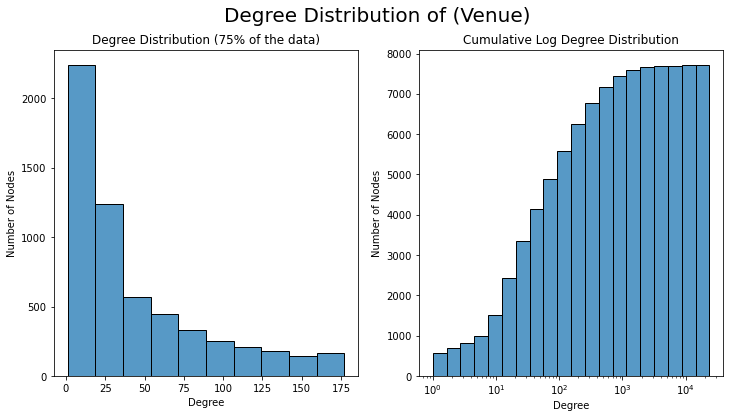

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Author)


,value,label
0,18243,
1,1986,Jr.
2,588,Philip S. Yu
3,567,Chin-Chen Chang
4,554,Elisa Bertino
5,534,Thomas S. Huang
6,501,Wen Gao
7,487,Wei Wang
8,484,Edwin R. Hancock
9,481,Ming Li


Top 10 Degree Nodes of Type (Paper)


,value,label
0,4476,Computers and Intractability: A Guide to the T...
1,2376,C4.5: Programs for Machine Learning
2,2295,Introduction to Algorithms
3,1578,Communicating Sequential Processes
4,1558,"Compilers: Princiles, Techniques, and Tools."
5,1451,Mining Association Rules between Sets of Items...
6,1433,Fast Algorithms for Mining Association Rules i...
7,1355,Introduction to Modern Information Retrieval.
8,1258,Graph-Based Algorithms for Boolean Function Ma...
9,1200,Concurrency Control and Recovery in Database S...


Top 10 Degree Nodes of Type (Venue)


,value,label
0,23730,CoRR
1,10236,ICRA
2,10204,Discrete Mathematics
3,9234,Commun. ACM
4,8403,Theor. Comput. Sci.
5,7889,IEICE Transactions
6,7465,"Microwave Theory and Techniques, IEEE Transact..."
7,7385,IEEE Transactions on Information Theory
8,7092,Electronics Letters
9,6346,HICSS


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
AUTHORED,AUTHORED,4285548
CITED,CITED,2327450
PUBLISHED_IN,PUBLISHED_IN,1630753


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

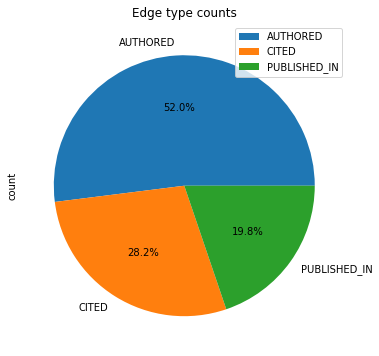

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Author


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006815,,0.003009,,1.0,Nikhil V. Shirahatti
1,0.000742,Jr.,0.000111,Jr.,1.0,Harri Pennanen
2,0.000220,Philip S. Yu,0.000041,Chin-Chen Chang,1.0,Aldo Dall'Osso
3,0.000212,Chin-Chen Chang,0.000039,Diane Crawford,1.0,Laurie B. Waisel
4,0.000207,Elisa Bertino,0.000039,Grzegorz Rozenberg,1.0,Tien-Chai Lin
5,0.000199,Thomas S. Huang,0.000038,Edwin R. Hancock,1.0,Nancy Clark
6,0.000187,Wen Gao,0.000034,Thomas S. Huang,1.0,Vibeke Luk
7,0.000182,Wei Wang,0.000033,Robert L. Glass,1.0,Johann Notbauer
8,0.000181,Edwin R. Hancock,0.000032,Wei Wang,1.0,Kathleen Scalise
9,0.000180,Ming Li,0.000031,Sudhakar M. Reddy,1.0,Andrew V. Sokolov


Top 10 Nodes by Statistic for Paper


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001672,Computers and Intractability: A Guide to the T...,0.000104,Computers and Intractability: A Guide to the T...,1.000000,"Objektorientierte Datenbanken: Konzepte, Model..."
1,0.000888,C4.5: Programs for Machine Learning,0.000066,C4.5: Programs for Machine Learning,1.000000,Parallel Evaluation of Deductive Database Quer...
2,0.000857,Introduction to Algorithms,0.000052,Introduction to Algorithms,1.000000,"Objektorientierte Datenbanken: Konzepte, Model..."
3,0.000590,Communicating Sequential Processes,0.000045,The MINOS scintillator calorimeter system,1.000000,Augmenting Databases with Generalized Transiti...
4,0.000582,"Compilers: Princiles, Techniques, and Tools.",0.000036,Communicating Sequential Processes,1.000000,Adaptive Optimization in a Database Programmin...
5,0.000542,Mining Association Rules between Sets of Items...,0.000034,Mining Association Rules between Sets of Items...,1.000000,Temporal Reasoning in Active Databases.
6,0.000535,Fast Algorithms for Mining Association Rules i...,0.000031,"Compilers: Princiles, Techniques, and Tools.",1.000000,Efficient View Maintenance at Data Warehouses.
7,0.000506,Introduction to Modern Information Retrieval.,0.000027,Graph-Based Algorithms for Boolean Function Ma...,1.000000,Shadow Paging Is Feasible.
8,0.000470,Graph-Based Algorithms for Boolean Function Ma...,0.000026,Introduction to Modern Information Retrieval.,1.000000,Management of Sequence Data
9,0.000448,Concurrency Control and Recovery in Database S...,0.000025,Computational Geometry - An Introduction.,0.952381,Risk in Control. On the Notion of Risk Function.


Top 10 Nodes by Statistic for Venue


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.008865,CoRR,0.002309,CoRR,0.178462,FOSE
1,0.003824,ICRA,0.001139,Discrete Mathematics,0.166667,Foundations and Trends in Web Science
2,0.003812,Discrete Mathematics,0.000868,"Microwave Theory and Techniques, IEEE Transact...",0.086154,ICSE - Future of SE Track
3,0.003450,Commun. ACM,0.000852,ICRA,0.080481,TVS
4,0.003139,Theor. Comput. Sci.,0.000788,Commun. ACM,0.066667,Topics in Information Systems
5,0.002947,IEICE Transactions,0.000761,IEEE Transactions on Information Theory,0.066667,CIKM-KRAS
6,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.000722,"Antennas and Propagation, IEEE Transactions on",0.058824,ICFP-WGP
7,0.002759,IEEE Transactions on Information Theory,0.000708,"Automatic Control, IEEE Transactions on",0.049261,Handbook of Automated Reasoning
8,0.002649,Electronics Letters,0.000663,Applied Mathematics and Computation,0.047619,"SIGMOD Workshop, Vol. 2"
9,0.002371,HICSS,0.000627,IEICE Transactions,0.047619,Applications of Uncertainty Formalisms


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7568142195827037
Number of communities: 109


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

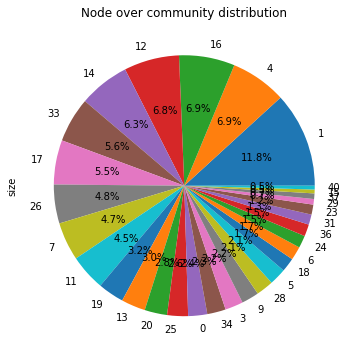

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006815,,0.003009,,1.000000,Jochen Kolzer
1,0.002789,"Microwave Theory and Techniques, IEEE Transact...",0.000868,"Microwave Theory and Techniques, IEEE Transact...",1.000000,John T. Ellis
2,0.001562,IEEE Computer,0.000464,Encyclopedia of Database Systems,1.000000,Karl R. Umstadter
3,0.001146,Encyclopedia of Database Systems,0.000382,IEEE Computer,1.000000,Jim Barton
4,0.000798,KI,0.000249,KI,1.000000,Paul Heckel
5,0.000722,"Microwave Symposium Digest, MTT-S International",0.000232,Encyclopedia of GIS,1.000000,Don L. Millard
6,0.000593,Informatik Spektrum,0.000227,"Microwave Symposium Digest, MTT-S International",1.000000,Robert C. Block
7,0.000592,IEEE Design & Test of Computers,0.000219,Informatik Spektrum,1.000000,John E. Collins
8,0.000564,Encyclopedia of GIS,0.000187,Encyclopedia of Biometrics,0.714286,Everything Is Alive.
9,0.000476,IEEE Internet Computing,0.000166,First Monday,0.700000,Dark Matter Revisited.


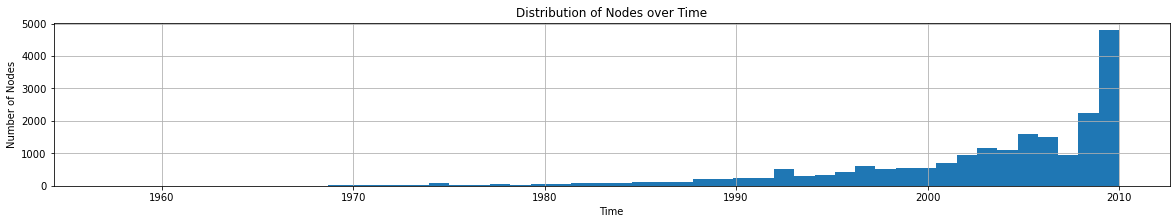

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002649,Electronics Letters,0.000722,"Antennas and Propagation, IEEE Transactions on",1.0,Mohamed Kawokgy
1,0.002292,"Antennas and Propagation, IEEE Transactions on",0.000708,"Automatic Control, IEEE Transactions on",1.0,M. Librizzi
2,0.002147,"Automatic Control, IEEE Transactions on",0.000626,Electronics Letters,1.0,E. Gallopoulos
3,0.001844,"Magnetics, IEEE Transactions on",0.000388,"Magnetics, IEEE Transactions on",1.0,M. Alduraibi
4,0.000942,"Acoustics, Speech and Signal Processing, IEEE ...",0.000300,"Acoustics, Speech and Signal Processing, IEEE ...",1.0,V. N. Dang
5,0.000742,Jr.,0.000162,"Electron Devices, IEEE Transactions on",1.0,Magnus Strömgren
6,0.000742,"Electron Devices, IEEE Transactions on",0.000139,"Quantum Electronics, IEEE Journal of",0.5,A low-power CSCD asynchronous viterbi decoder ...
7,0.000689,"Nuclear Science, IEEE Transactions on",0.000135,"Photonics Technology Letters, IEEE",0.5,On the numerical approximation of a degenerate...
8,0.000686,"Photonics Technology Letters, IEEE",0.000134,"Components, Hybrids, and Manufacturing Technol...",0.5,(Monte Carlo) time after time
9,0.000607,"Quantum Electronics, IEEE Journal of",0.000131,"Signal Processing, IEEE Transactions on",0.5,Algorithm 365: complex root finding [C5].


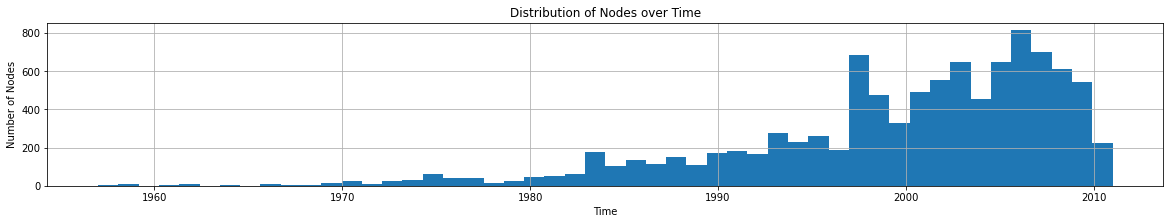

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000114,Journal of Quantitative Linguistics,0.000040,Journal of Quantitative Linguistics,0.166667,Stephan Guttowski
1,0.000090,"Microwave and Telecommunication Technology, 20...",0.000022,"Microwave and Telecommunication Technology, 20...",0.166667,What is important in electronic textbooks for ...
2,0.000072,"Millimeter Wave and Far-Infrared Technology, 1...",0.000020,Mathematical Methods in Electromagnetic Theory...,0.000000,The 15 K Magnetic Phase Transition In Bi2CuO A...
3,0.000066,Mathematical Methods in Electromagnetic Theory...,0.000018,"Millimeter Wave and Far-Infrared Technology, 1...",0.000000,Elastic And Unelastic Relaxation Mechanisms In...
4,0.000052,"Surface Waves in Solid and Layered Structures,...",0.000014,"Surface Waves in Solid and Layered Structures,...",0.000000,Acoustoelectronical Devices For Forming And De...
5,0.000042,"Modern Technique and Technologies, 2002. MTT 2...",0.000013,"Modern Technique and Technologies, 2002. MTT 2...",0.000000,SAW And Leaky Waves In A New Piezoelectric Cry...
6,0.000037,"Artificial Intelligence Systems, 2002. (ICAIS ...",0.000011,"Artificial Intelligence Systems, 2002. (ICAIS ...",0.000000,On Effective Excitation Of The Radial Vibratio...
7,0.000034,EMV,0.000010,EMV,0.000000,Method Of Synthesis Of The Multilayered Struct...
8,0.000032,"Science and Technology, 2001. KORUS '01. Proce...",0.000008,"Science and Technology, 2001. KORUS '01. Proce...",0.000000,Ultrasonic-Resonance Spectroscopy Of Bulk And ...
9,0.000029,Physics and Engineering of Millimeter and Subm...,0.000008,Physics and Engineering of Millimeter and Subm...,0.000000,A. Azizzadeh


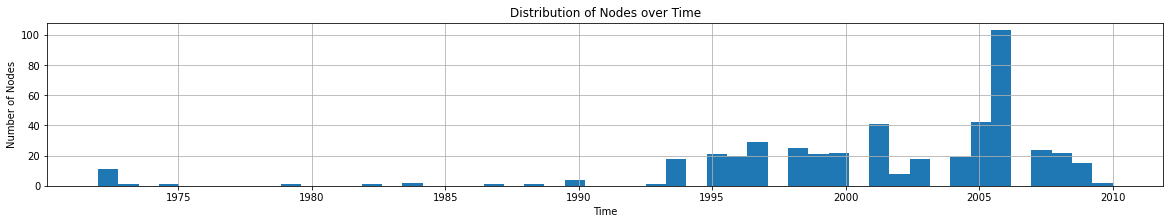

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000491,CIT,0.000106,CIT,1.000000,Halisson Brito
1,0.000369,CSCWD,0.000080,CSCWD,1.000000,Shang Chen
2,0.000285,ICIC (2),0.000062,ICMLC,1.000000,David J. Hill 0002
3,0.000272,ICMLC,0.000061,ICIC (2),1.000000,Jiachen Hou
4,0.000236,ACIS-ICIS,0.000055,ACIS-ICIS,1.000000,Wei-Sung Yeh
5,0.000220,GCC,0.000050,WKDD,1.000000,G. Faraco
6,0.000208,NCM,0.000048,NCM,0.833333,Digital inpainting: a tutorial.
7,0.000206,Geoinformatics,0.000048,JCP,0.666667,Derivatives of multidimensional Bernstein oper...
8,0.000202,Science in China Series F: Information Sciences,0.000046,GCC,0.666667,Diabetic Damage Detection in Retinal Images Vi...
9,0.000200,ICYCS,0.000045,Science in China Series F: Information Sciences,0.666667,A Parallel Implementation of the PBSGDS Method...


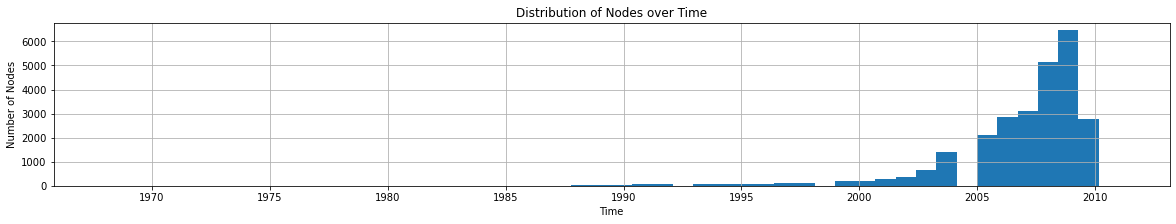

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001881,INFOCOM,0.000401,INFOCOM,1.0,Ausama Yousef
1,0.001555,GLOBECOM,0.000329,GLOBECOM,1.0,Mateusz Malinowski
2,0.001463,Computer Communications,0.000305,Computer Communications,1.0,Anthony Hung
3,0.001338,ICC,0.000291,ICC,1.0,Yubing Wang
4,0.001155,VTC Spring,0.000252,VTC Spring,1.0,Donald Krieger
5,0.001135,Computer Networks,0.000241,IEEE Transactions on Wireless Communications,1.0,Matthew K. H. Leung
6,0.001039,IEEE Transactions on Wireless Communications,0.000194,IEEE Journal on Selected Areas in Communications,1.0,Matthew Millard
7,0.000838,IEEE Journal on Selected Areas in Communications,0.000183,Computer Networks,1.0,Helge Backhaus
8,0.000800,ICDCS,0.000170,ICDCS,1.0,Hemant Banavar
9,0.000723,VTC Fall,0.000158,VTC Fall,1.0,Ron Cocchi


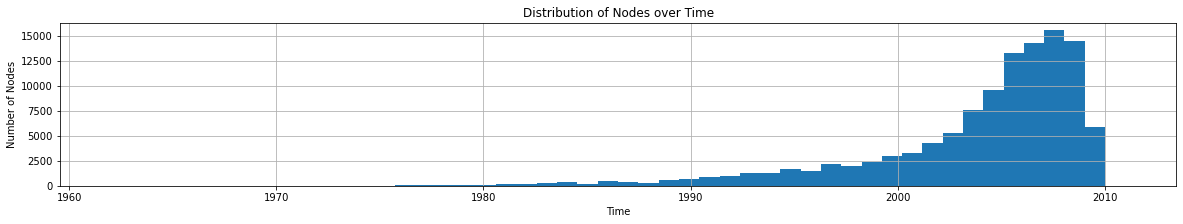

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.002236,Applied Mathematics and Computation,0.000663,Applied Mathematics and Computation,1.0,Sonjoy Das
1,0.000858,Appl. Math. Lett.,0.000264,Appl. Math. Lett.,1.0,Igor E. Poloskov
2,0.000695,I. J. Bifurcation and Chaos,0.000181,I. J. Bifurcation and Chaos,1.0,David M. Hough
3,0.000655,J. Symb. Comput.,0.000149,J. Symb. Comput.,1.0,Laura V. Pérez
4,0.000534,Computer Physics Communications,0.000135,Computer Physics Communications,1.0,Lília de Sá Silva
5,0.000487,Mathematics and Computers in Simulation,0.000126,Computing,1.0,Tai-Lin Wang
6,0.000417,Computing,0.000113,Mathematics and Computers in Simulation,1.0,Laurentiu Biscu
7,0.000406,ISSAC,0.000108,SIAM Journal of Applied Mathematics,1.0,Lauri Ilison
8,0.000384,SIAM Journal of Applied Mathematics,0.000100,Journal of Approximation Theory,1.0,S. Cabay
9,0.000355,Journal of Approximation Theory,0.000094,Math. Comput.,1.0,Jörn Springer


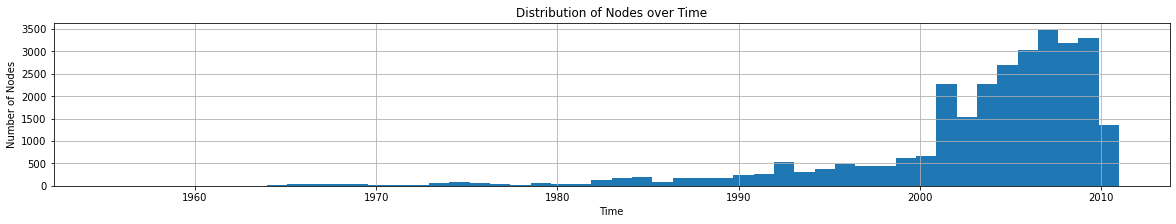

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.3347457143341299
Number of communities: 72843


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

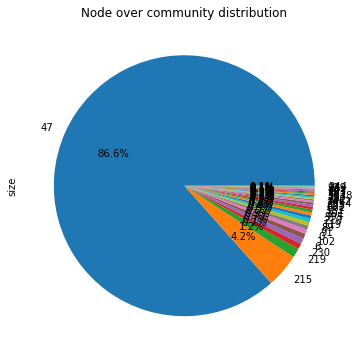

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006815,,0.003009,,0.0,
1,0.000458,Encyclopedia of Biometrics,0.000187,Encyclopedia of Biometrics,0.0,Proceedings of HotOS'05: 10th Workshop on Hot ...
2,0.000099,Encyclopedia of Multimedia,0.000038,Encyclopedia of Multimedia,0.0,10th IEEE International Conference on High Per...
3,0.000037,FDT - Bulletin of ACM SIGFIDET,0.000015,FDT - Bulletin of ACM SIGFIDET,0.0,17th Annual International Symposium on High Pe...
4,0.000016,"Audio and Electroacoustics Newsletter, IEEE",0.000007,"Audio and Electroacoustics Newsletter, IEEE",0.0,19th Annual International Symposium on High Pe...
5,0.000008,Communications Society: A Digest of News and E...,0.000003,Communications Society: A Digest of News and E...,0.0,20th Annual International Symposium on High Pe...
6,0.000006,"Circuits and Systems Magazine, IEEE",0.000002,Embedded Systems and the Year 2000 Problem: Gu...,0.0,21st Annual International Symposium on High Pe...
7,0.000006,"Power and Energy Magazine, IEEE",0.000002,"Power and Energy Magazine, IEEE",0.0,10th IEEE International Symposium on High Perf...
8,0.000006,Embedded Systems and the Year 2000 Problem: Gu...,0.000002,"Optical Fiber Communication Conference, 1999, ...",0.0,13th International Symposium on High-Performan...
9,0.000005,"Optical Fiber Communication Conference, 1999, ...",0.000002,"Circuits and Systems Magazine, IEEE",0.0,Proceedings of the IADIS International Confere...


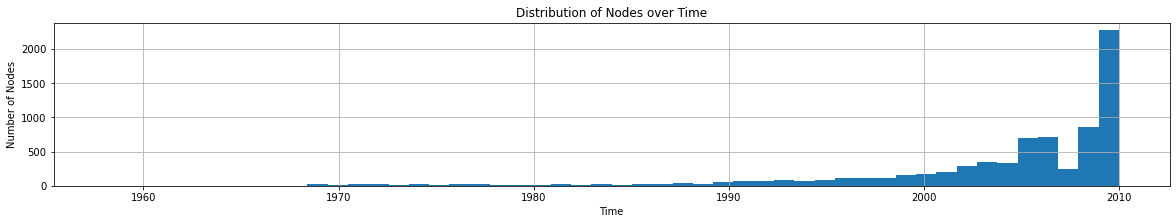

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000742,Jr.,0.000111,Jr.,0.0,A.
1,0.000071,J.,0.000012,J.,0.0,"Algebraic, mathematical programming, and netwo..."
2,0.000052,C.,0.000008,C.,0.0,Magnetism of new semi-Heusler compounds FeVSn ...
3,0.000040,R.,0.000007,R.,0.0,Role of nitrogen concentration in the thermal ...
4,0.000039,A.,0.000006,A.,0.0,High moment epitaxial Fe-N thin films
5,0.000034,W.,0.000006,W.,0.0,Blue-green laser diodes on ZnSe substrates
6,0.000027,L.,0.000004,L.,0.0,Electromagnetic energy exposure of simulated u...
7,0.000021,F.,0.000004,E.,0.0,Ill-convergence of Godard blind equalizers in ...
8,0.000021,E.,0.000004,F.,0.0,Angle and polarization estimation using ESPRIT...
9,0.000020,Peters,0.000003,J. Markel,0.0,Image filtering with orthogonal projectors for...


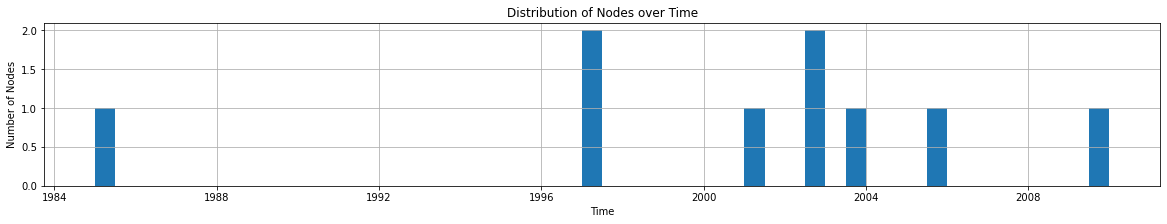

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000409,"Information Theory, IEEE Transactions on",0.000127,"Information Theory, IEEE Transactions on",0.0,A. Ashikhmin
1,0.000009,S. Shamai,0.000003,S. Shamai,0.0,Multiterminal detection with zero-rate data co...
2,0.000008,J. Bruck,0.000002,J. Bruck,0.0,A note on the competitive optimality of the Hu...
3,0.000007,S. Verdu,0.000002,N. Merhav,0.0,On universal quantization by randomized unifor...
4,0.000007,G. Cohen,0.000002,S. Verdu,0.0,On the rate-distortion efficiency of subband c...
5,0.000007,N. Merhav,0.000002,A. Dembo,0.0,On the construction of statistically synchroni...
6,0.000006,T. Fujiwara,0.000002,T.A. Gulliver,0.0,On the optimal asymptotic performance of unive...
7,0.000006,A. Dembo,0.000002,M. Feder,0.0,Performance bounds for noncoherent detection u...
8,0.000006,J. Ziv,0.000002,J. Ziv,0.0,Identifiability of hidden Markov information s...
9,0.000006,A.R. Calderbank,0.000002,G. Cohen,0.0,A universal variable-to-fixed length source co...


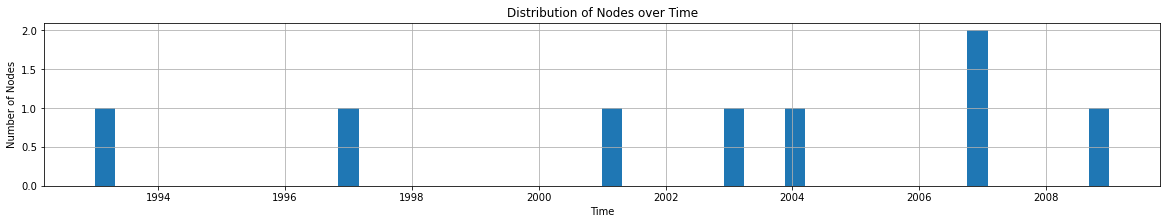

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,2.615095e-06,Remote sensing of dipole rings,9.563095e-07,Remote sensing of dipole rings,0.0,A.D.
1,2.241510e-06,Detecting &ldquo;dipole ring&rdquo; separatric...,6.387623e-07,Detecting &ldquo;dipole ring&rdquo; separatric...,0.0,J.W. Brown
2,1.120755e-06,A.D.,1.940195e-07,A.D.,0.0,Kirwan
3,7.471700e-07,J.W. Brown,1.543261e-07,J.W. Brown,0.0,S.B. Hooker
4,7.471700e-07,Kirwan,1.543261e-07,Kirwan,0.0,Remote sensing of dipole rings
5,7.471700e-07,S.B. Hooker,1.543261e-07,S.B. Hooker,0.0,Detecting &ldquo;dipole ring&rdquo; separatric...
6,3.735850e-07,R.P. Mied,1.014016e-07,R.P. Mied,NaN,R.P. Mied


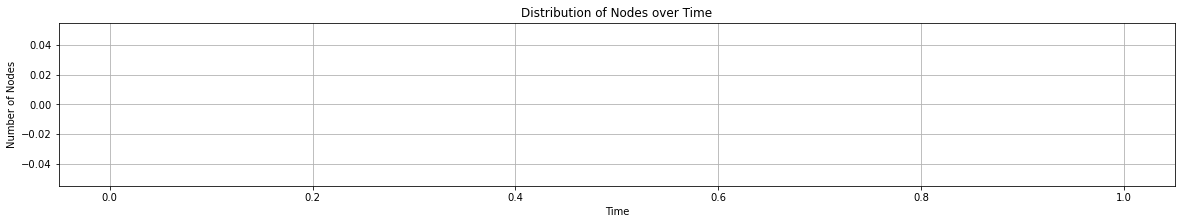

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,4.109435e-06,Estimating net joint torques from kinesiologic...,1.751255e-06,Estimating net joint torques from kinesiologic...,0.0,A.E.
1,1.867925e-06,Estimating joint torques from kinematic and re...,7.973632e-07,Estimating joint torques from kinematic and re...,0.0,C.F. Runge
2,1.120755e-06,A.E.,2.707601e-07,F.E. Zajac,0.0,F.E. Zajac
3,1.120755e-06,F.E. Zajac,1.586585e-07,A.E.,0.0,J.H.J. Allum
4,7.471700e-07,C.F. Runge,1.484151e-07,C.F. Runge,0.0,Zajac
5,7.471700e-07,J.H.J. Allum,1.484151e-07,J.H.J. Allum,0.0,Estimating joint torques from kinematic and re...
6,7.471700e-07,Zajac,1.378302e-07,Zajac,0.0,Estimating net joint torques from kinesiologic...
7,3.735850e-07,F.E.,1.195472e-07,A.E. Bryson,NaN,F.E.
8,3.735850e-07,A.E. Bryson,8.490565e-08,F.E.,NaN,A.E. Bryson
9,3.735850e-07,D.W. Risher,8.490565e-08,D.W. Risher,NaN,D.W. Risher


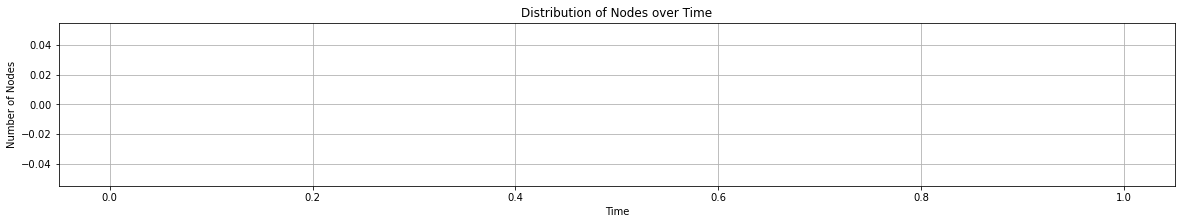

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,4.109435e-06,An improved technique and experimental results...,1.002744e-06,An improved technique and experimental results...,0.0,A.F.
1,2.988680e-06,Temperature dependence characterization of eff...,8.078858e-07,Temperature dependence characterization of eff...,0.0,G.L. Chindalore
2,2.988680e-06,Parametric study of latchup immunity of deep t...,6.226500e-07,A comprehensive model for inversion layer hole...,0.0,S. Mudanai
3,2.615095e-06,A comprehensive model for inversion layer hole...,3.049204e-07,A.F.,0.0,Tasch
4,2.241510e-06,A.F.,2.962032e-07,Parametric study of latchup immunity of deep t...,0.0,W.-K. Shih
5,1.867925e-06,Tasch,2.414110e-07,Tasch,0.0,An improved technique and experimental results...
6,1.120755e-06,G.L. Chindalore,2.039858e-07,G.L. Chindalore,0.0,Temperature dependence characterization of eff...
7,1.120755e-06,W.-K. Shih,1.699629e-07,W.-K. Shih,0.0,Parametric study of latchup immunity of deep t...
8,7.471700e-07,S. Mudanai,1.245990e-07,S. Mudanai,0.0,A comprehensive model for inversion layer hole...
9,3.735850e-07,Agostinelli,1.014016e-07,Agostinelli,NaN,Agostinelli


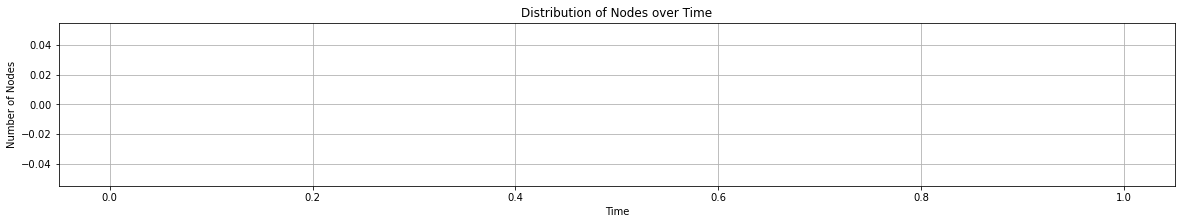

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')